# Organize the data Directory

In [14]:
import os
import shutil
import re

In [ ]:
!unzip data.zip

In [15]:
# Directory containing our images
data_dir = 'data'

# Directory containing our training images
train_dir = './data/train'
train_dogs_dir = f'{train_dir}/dog'
train_cats_dir = f'{train_dir}/cat'

# Directory containing our validation images
val_dir = "./data/val"
val_dogs_dir = f'{val_dir}/dog'
val_cats_dir = f'{val_dir}/cat'

# Directory containing our test images
test_dir = './data/testset/test'


In [16]:
# Create Dog validation directory and move validation images
dog_files = os.listdir(train_dogs_dir)

for f in dog_files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)

# Create Cat validation directory and move validation images
cat_files = os.listdir(train_cats_dir)
for f in cat_files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)

# Data Preprocessing

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import math

In [8]:
# Compose the different transforms we will be applying to our images
tsfrm = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# Create the Dataset object and wrap the object with a Dataloader
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              tsfrm[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}

# Verify dataloader is correct by checking size and class name
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes
print(class_names) 
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


RuntimeError: Found 0 files in subfolders of: data/val
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif

In [7]:
def imshow(img, title=None):
    """Imshow for our Images.
    The title will be made of 0 (cats) and 1 (dogs)"""
    # Convert to numpy
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
        

/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


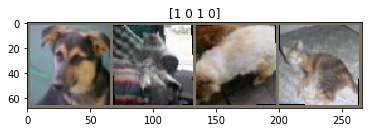

In [8]:
# Get a batch (based on batch size set in Dataloader) of training data
inputs, classes = next(iter(dataloaders['train']))
labels = classes.numpy()

# Make a grid and show images
samples = torchvision.utils.make_grid(inputs)
imshow(samples, title=labels)



In [9]:
# Check shape is correct (First number should be batch size, then 3, 64, 64)
print(inputs.shape)

torch.Size([4, 3, 64, 64])


# Training 

In [10]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # 3 x 64 x 64 -> 6 x 60 x 60
        x = self.pool(x)            # 6 x 60 x 60 -> 6 x 30 x 30
        x = F.relu(self.conv2(x))   # 6 x 30 x 30 -> 16 x 24 x 24
        x = self.pool(x)            # 16 x 24 x 24 -> 16 x 12 x 12
        x = x.view(-1, 16 * 12 * 12)  # flatten
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [49]:
def train_model(model, criterion, optimizer, num_epochs=5, checkpoint=None):
    since = time.time()
    
    # Check if checkpoint available. 
    print(checkpoint)
    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        # If checkpoint exists, start from last checkpoint and load checkpoint state.
        print('Val loss: {}, Val accuracy: {}'.format(checkpoint['best_val_loss'], checkpoint['best_val_accuracy']))
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    # Create list for storing losses for plotting use
    val_loss_list = []
    train_loss_list = []
    val_acc_list = []
    train_acc_list = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        

        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            

            running_loss = 0.
            running_corrects = 0
              
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
    
                # Print every 250 images
                if i % 250 == 249:
                    print('[%d, %d] loss: %.3f' % (epoch + 1, i, running_loss / (i * inputs.size(0))))
                    
                # Forward pass (track only if training)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass (optimize only if training)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            

            # Get loss and accuracy for epochs
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            if phase == 'val':
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            # Make a deep copy of the best model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # Load weights of resulting best model
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list
            

# Utils for visualization of model and learning curves

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images += 1
                ax = plt.subplot(num_images//2, 2, images)
                ax.axis('off')
                ax.set_title('Prediction: {}'.format(class_names[predictions[j]]))
                imshow(inputs.cpu().data[j])

                if images == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
def plot_learning_curve():

SyntaxError: unexpected EOF while parsing (<ipython-input-13-e9fe68959272>, line 1)

# Models

### Best Model

In [34]:
# Initialize model and hyperparameters
model_1 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001)
num_epochs = 25

model_1 = model_1.to(device)

In [50]:
CHECKPOINT = 'checkpoint_best_model.tar'


In [51]:
try:
    checkpoint = torch.load(CHECKPOINT)
    print("Checkpoint Found")
except:
    checkpoint = None
    print("Checkpoint Not Found")
    

model_1, best_val_loss, best_val_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_model(model_1,
                                                              criterion,
                                                              optimizer,
                                                              num_epochs,
                                                              checkpoint = checkpoint)
torch.save({'model_state_dict': model_1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc
            }, CHECKPOINT)

Checkpoint Not Found
None
Epoch 0/24
----------
[1, 249] loss: 0.277
[1, 499] loss: 0.262
[1, 749] loss: 0.264
[1, 999] loss: 0.269
[1, 1249] loss: 0.268
[1, 1499] loss: 0.268
[1, 1749] loss: 0.269
[1, 1999] loss: 0.268
[1, 2249] loss: 0.268
[1, 2499] loss: 0.267
[1, 2749] loss: 0.268
[1, 2999] loss: 0.269
[1, 3249] loss: 0.269
[1, 3499] loss: 0.269
[1, 3749] loss: 0.269
[1, 3999] loss: 0.271
[1, 4249] loss: 0.270
[1, 4499] loss: 0.544
train Loss: 0.2723 Acc: 0.8836
[1, 249] loss: 0.543
[1, 499] loss: 0.535
val Loss: 0.5345 Acc: 0.7765
New best model found!
New record loss: 0.5344702351391315, previous record loss: inf

Epoch 1/24
----------
[2, 249] loss: 0.251
[2, 499] loss: 0.251
[2, 749] loss: 0.254
[2, 999] loss: 0.258
[2, 1249] loss: 0.255
[2, 1499] loss: 0.256
[2, 1749] loss: 0.255
[2, 1999] loss: 0.256
[2, 2249] loss: 0.257
[2, 2499] loss: 0.255
[2, 2749] loss: 0.258
[2, 2999] loss: 0.260
[2, 3249] loss: 0.262
[2, 3499] loss: 0.262
[2, 3749] loss: 0.263
[2, 3999] loss: 0.262
[2

[16, 2249] loss: 0.148
[16, 2499] loss: 0.148
[16, 2749] loss: 0.150
[16, 2999] loss: 0.152
[16, 3249] loss: 0.152
[16, 3499] loss: 0.154
[16, 3749] loss: 0.151
[16, 3999] loss: 0.152
[16, 4249] loss: 0.153
[16, 4499] loss: 0.304
train Loss: 0.1522 Acc: 0.9397
[16, 249] loss: 0.739
[16, 499] loss: 0.709
val Loss: 0.7092 Acc: 0.7860

Epoch 16/24
----------
[17, 249] loss: 0.147
[17, 499] loss: 0.134
[17, 749] loss: 0.137
[17, 999] loss: 0.135
[17, 1249] loss: 0.134
[17, 1499] loss: 0.131
[17, 1749] loss: 0.128
[17, 1999] loss: 0.129
[17, 2249] loss: 0.132
[17, 2499] loss: 0.136
[17, 2749] loss: 0.137
[17, 2999] loss: 0.140
[17, 3249] loss: 0.139
[17, 3499] loss: 0.140
[17, 3749] loss: 0.140
[17, 3999] loss: 0.141
[17, 4249] loss: 0.143
[17, 4499] loss: 0.284
train Loss: 0.1421 Acc: 0.9430
[17, 249] loss: 0.772
[17, 499] loss: 0.761
val Loss: 0.7606 Acc: 0.7735

Epoch 17/24
----------
[18, 249] loss: 0.127
[18, 499] loss: 0.127
[18, 749] loss: 0.130
[18, 999] loss: 0.132
[18, 1249] loss:

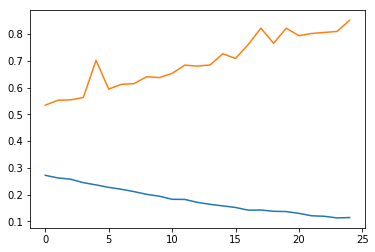

In [52]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

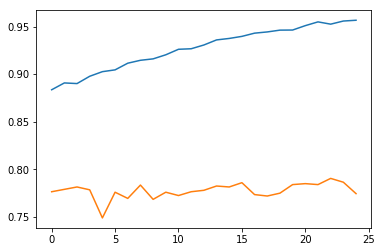

In [54]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)

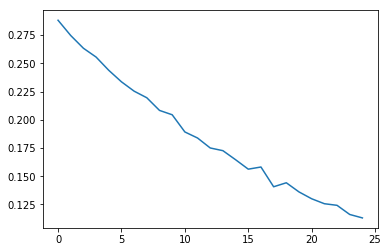

In [45]:
plt.plot(train_loss_list)

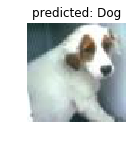

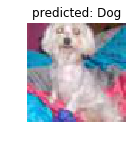

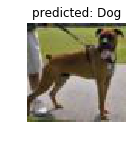

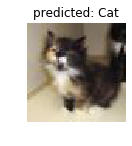

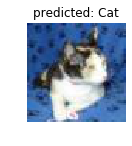

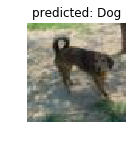

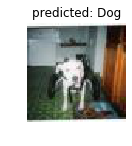

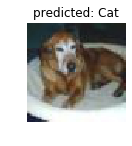

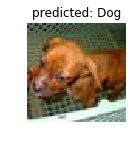

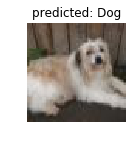

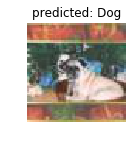

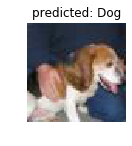

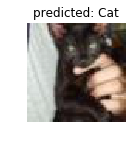

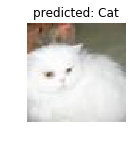

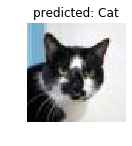

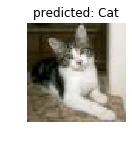

In [87]:
# Print some example of images and label predictions
visualize_model(model_1, 4)
visualize_model(model_1, 4)
visualize_model(model_1, 4)
visualize_model(model_1, 4)

plt.ioff()
plt.show()

### Other Models

Increasing Learning Rate

In [ ]:
# Model 4
checkpoint_4 = 'checkpoint_4.tar'
model_4 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.05)
num_epochs = 50
model_4 = model_4.to(device)

try:
    cp = torch.load(checkpoint)
    print("checkpoint loaded")
except:
    cp = None
    print("checkpoint not found")


model, best_val_loss, best_val_acc, train_loss_list, val_loss_list = train_model(model_4, criterion,optimizer,num_epochs=50,checkpoint = cp)

torch.save({'model_state_dict': model_4.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc
            }, checkpoint_4)

checkpoint not found
None
Epoch 0/49
----------
[1, 249] loss: 0.695
[1, 499] loss: 0.695
[1, 749] loss: 0.694
[1, 999] loss: 0.694
[1, 1249] loss: 0.693
[1, 1499] loss: 0.693
[1, 1749] loss: 0.693
[1, 1999] loss: 0.693
[1, 2249] loss: 0.692
[1, 2499] loss: 0.692
[1, 2749] loss: 0.691
[1, 2999] loss: 0.691
[1, 3249] loss: 0.691
[1, 3499] loss: 0.690
[1, 3749] loss: 0.690
[1, 3999] loss: 0.689
[1, 4249] loss: 0.689
[1, 4499] loss: 1.376
train Loss: 0.6879 Acc: 0.5588
[1, 249] loss: 0.677
[1, 499] loss: 0.678
val Loss: 0.6783 Acc: 0.5910
New best model found!
New record loss: 0.6783085205554962, previous record loss: inf

Epoch 1/49
----------
[2, 249] loss: 0.676
[2, 499] loss: 0.672
[2, 749] loss: 0.672
[2, 999] loss: 0.671
[2, 1249] loss: 0.671
[2, 1499] loss: 0.669
[2, 1749] loss: 0.668
[2, 1999] loss: 0.666
[2, 2249] loss: 0.665
[2, 2499] loss: 0.665
[2, 2749] loss: 0.664
[2, 2999] loss: 0.662
[2, 3249] loss: 0.661
[2, 3499] loss: 0.660
[2, 3749] loss: 0.658
[2, 3999] loss: 0.656
[2

[14, 3249] loss: 0.494
[14, 3499] loss: 0.494
[14, 3749] loss: 0.494
[14, 3999] loss: 0.493
[14, 4249] loss: 0.492
[14, 4499] loss: 0.985
train Loss: 0.4924 Acc: 0.7629
[14, 249] loss: 0.499
[14, 499] loss: 0.496
val Loss: 0.4953 Acc: 0.7515
New best model found!
New record loss: 0.49530015158653257, previous record loss: 0.5041662093847991

Epoch 14/49
----------
[15, 249] loss: 0.474
[15, 499] loss: 0.491
[15, 749] loss: 0.490
[15, 999] loss: 0.486
[15, 1249] loss: 0.486
[15, 1499] loss: 0.486
[15, 1749] loss: 0.481
[15, 1999] loss: 0.480
[15, 2249] loss: 0.480
[15, 2499] loss: 0.480
[15, 2749] loss: 0.480
[15, 2999] loss: 0.481
[15, 3249] loss: 0.479
[15, 3499] loss: 0.480
[15, 3749] loss: 0.481
[15, 3999] loss: 0.480
[15, 4249] loss: 0.481
[15, 4499] loss: 0.962
train Loss: 0.4809 Acc: 0.7700
[15, 249] loss: 0.503
[15, 499] loss: 0.495
val Loss: 0.4954 Acc: 0.7490

Epoch 15/49
----------
[16, 249] loss: 0.483
[16, 499] loss: 0.484
[16, 749] loss: 0.478
[16, 999] loss: 0.476
[16, 12

[28, 249] loss: 0.486
[28, 499] loss: 0.495
val Loss: 0.4951 Acc: 0.7740

Epoch 28/49
----------
[29, 249] loss: 0.355
[29, 499] loss: 0.347
[29, 749] loss: 0.339
[29, 999] loss: 0.339
[29, 1249] loss: 0.345
[29, 1499] loss: 0.346
[29, 1749] loss: 0.347
[29, 1999] loss: 0.347


In [ ]:
# Model 3
checkpoint_3 = 'checkpoint3.tar''
model_3 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.01)
num_epochs = 60
model_2 = model_3.to(device)

In [23]:
# Model 4
checkpoint_4 = 'checkpoint_5.tar'
model_4 = Simple_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.05)
num_epochs = 3
model_4 = model_4.to(device)

try:
    cp = torch.load(checkpoint)
    print("checkpoint loaded")
except:
    cp = None
    print("checkpoint not found")


model, best_val_loss, best_val_acc, train_loss_list, val_loss_list = train_model(model_4, criterion,optimizer,num_epochs=5,checkpoint = cp)

torch.save({'model_state_dict': model_4.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc
            }, checkpoint_4)

checkpoint not found
None
Epoch 0/4
----------
[1, 249] loss: 0.695
[1, 499] loss: 0.692
[1, 749] loss: 0.691
[1, 999] loss: 0.688
[1, 1249] loss: 0.685
[1, 1499] loss: 0.683
[1, 1749] loss: 0.680
[1, 1999] loss: 0.678
[1, 2249] loss: 0.676
[1, 2499] loss: 0.674
[1, 2749] loss: 0.670
[1, 2999] loss: 0.668
[1, 3249] loss: 0.665
[1, 3499] loss: 0.666
[1, 3749] loss: 0.664
[1, 3999] loss: 0.663
[1, 4249] loss: 0.661
[1, 4499] loss: 1.318
[]
train Loss: 0.6588 Acc: 0.6121
TRAIN   :  [0.6588186718567383]
[1, 249] loss: 0.655
[1, 499] loss: 0.653
[]
val Loss: 0.6536 Acc: 0.6585
VALID   :  [0.6535574524402619]
New best model found!
New record loss: 0.6535574524402619, previous record loss: inf

Epoch 1/4
----------
[2, 249] loss: 0.631
[2, 499] loss: 0.637
[2, 749] loss: 0.636
[2, 999] loss: 0.630
[2, 1249] loss: 0.625
[2, 1499] loss: 0.623
[2, 1749] loss: 0.622
[2, 1999] loss: 0.621
[2, 2249] loss: 0.618
[2, 2499] loss: 0.617
[2, 2749] loss: 0.617
[2, 2999] loss: 0.618
[2, 3249] loss: 0.618


In [24]:
print(train_loss_list)

[0.6588186718567383, 0.6588186718567383, 0.6138168105133005, 0.6138168105133005, 0.5873847253896327, 0.5873847253896327, 0.5747012263345035, 0.5747012263345035, 0.5662341998118614, 0.5662341998118614]


In [25]:
print(val_loss_list)

[0.6535574524402619, 0.6535574524402619, 0.5602319038212299, 0.5602319038212299, 0.569149040222168, 0.569149040222168, 0.5977277359068394, 0.5977277359068394, 0.538057095348835, 0.538057095348835]


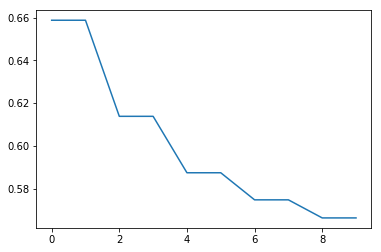

In [26]:
plt.plot(train_loss_list)


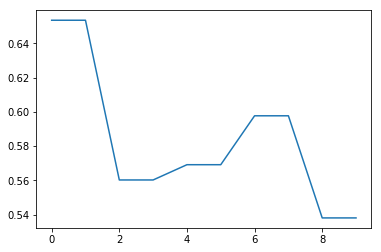

In [28]:
plt.plot(val_loss_list)


### Question 1: Describe Architecture

In [73]:
# Model Parameters
model_1

Simple_CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Question 2: Training and Validation Error Curves

In [81]:
plt.plot(running_loss_list)

Simple_CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Question 3: Hyperparameters

In [ ]:
# TO-DO

# Apply best model on test set and prepare data for submission

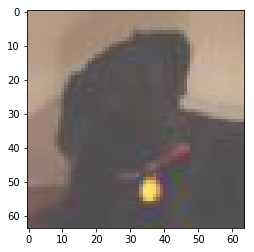

In [48]:
from PIL import Image

# Take images from test directory
test_files = os.listdir(test_dir)
img = Image.open(f'{test_dir}/{test_files[4]}')
plt.imshow(img)

In [49]:
def test_transforms(image):
    # Transforms to apply on test set
    img = transforms.functional.resize(image, [64,64])
    img = transforms.functional.to_tensor(img)
    img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return img

In [67]:
def get_file(fname):
    # Get file from filename
    print("Get File " + fname)
    return int(re.search('\d+', fname).group())

In [66]:
def prediction(model, fname):
    # Force image to be converted in RGB space. 
    # NOTE: 2 images in the test dataset are in the Gray space.
    img = Image.open(f'{test_dir}/{fname}')
    img = img.convert('RGB')

    # Apply transforms to test images
    img_tensor = test_transforms(img)
    minibatch = torch.stack([img_tensor])

    # Perform softmax probability on output layer
    softmax = nn.Softmax(dim = 1)
    prob = softmax(model(minibatch))
    prob_np = prob.detach().numpy()
    
    # Convert to 'Cat' or 'Dog'
    pred = np.argmax(prob_np)
    if pred == 0:
        return 'Cat'
    if pred == 1:
        return 'Dog'
    return predictions[0,1]

In [68]:
model_1.eval()
predictions = {get_file(fname):
    prediction(model_1, fname) for fname in test_files}


[[0.05418442 0.9458156 ]]
1
Get File 63.jpg
[[0.16000146 0.8399985 ]]
1
Get File 823.jpg
[[0.3535372  0.64646274]]
1
Get File 4217.jpg
[[0.34692276 0.6530773 ]]
1
Get File 3578.jpg
[[0.3532482  0.64675176]]
1
Get File 2666.jpg
[[0.9208361  0.07916383]]
0
Get File 2100.jpg
[[0.81344426 0.18655574]]
0
Get File 4571.jpg
[[0.00675905 0.99324095]]
1
Get File 1409.jpg
[[0.57774234 0.42225763]]
0
Get File 189.jpg
[[0.06389178 0.93610823]]
1
Get File 2114.jpg
[[0.72029907 0.2797009 ]]
0
Get File 4565.jpg
[[0.8263257  0.17367432]]
0
Get File 4203.jpg
[[0.38346398 0.616536  ]]
1
Get File 2672.jpg
[[0.2370631 0.7629369]]
1
Get File 77.jpg
[[0.7007801  0.29921997]]
0
Get File 837.jpg
[[0.41437265 0.5856273 ]]
1
Get File 2882.jpg
[[0.10239783 0.8976022 ]]
1
Get File 3544.jpg
[[0.29025474 0.7097452 ]]
1
Get File 1353.jpg
[[0.05557823 0.94442177]]
1
Get File 1435.jpg
[[0.80849344 0.19150653]]
0
Get File 3222.jpg
[[0.34074125 0.65925866]]
1
Get File 2128.jpg
[[0.4307689 0.5692311]]
1
Get File 3236.jpg

[[0.2944559  0.70554405]]
1
Get File 4821.jpg
[[0.6072242  0.39277574]]
0
Get File 3196.jpg
[[0.23834369 0.76165634]]
1
Get File 1959.jpg
[[0.1667708 0.8332292]]
1
Get File 1781.jpg
[[0.9097357  0.09026429]]
0
Get File 215.jpg
[[0.9306881  0.06931191]]
0
Get File 573.jpg
[[0.8896088  0.11039119]]
0
Get File 3828.jpg
[[0.0251784 0.9748216]]
1
Get File 3800.jpg
[[0.40560272 0.5943973 ]]
1
Get File 4809.jpg
[[0.06340697 0.93659294]]
1
Get File 1971.jpg
[[0.5374771  0.46252295]]
0
Get File 1965.jpg
[[0.281202   0.71879804]]
1
Get File 229.jpg
[[0.8259879  0.17401214]]
0
Get File 3814.jpg
[[0.6081864  0.39181364]]
0
Get File 1030.jpg
[[0.9288021 0.0711979]]
0
Get File 2539.jpg
[[0.92177755 0.07822245]]
0
Get File 3627.jpg
[[0.23967841 0.76032156]]
1
Get File 4148.jpg
[[0.79964775 0.20035225]]
0
Get File 3141.jpg
[[0.5544129  0.44558704]]
0
Get File 1756.jpg
[[0.02140841 0.9785917 ]]
1
Get File 1742.jpg
[[0.22424534 0.77575463]]
1
Get File 3155.jpg
[[0.71068656 0.28931344]]
0
Get File 3633.j

[[0.86949617 0.13050383]]
0
Get File 405.jpg
[[0.99077165 0.00922831]]
0
Get File 1191.jpg
[[0.28522474 0.71477526]]
1
Get File 363.jpg
[[0.2958544 0.7041456]]
1
Get File 4957.jpg
[[0.6896026  0.31039742]]
0
Get File 2261.jpg
[[0.33075863 0.66924137]]
1
Get File 4610.jpg
[[0.99310595 0.0068941 ]]
0
Get File 1768.jpg
[[0.89582074 0.10417928]]
0
Get File 4176.jpg
[[0.86819834 0.13180168]]
0
Get File 3619.jpg
[[0.14665271 0.8533473 ]]
1
Get File 2507.jpg
[[0.07532808 0.92467195]]
1
Get File 4162.jpg
[[0.31773672 0.6822633 ]]
1
Get File 2513.jpg
[[0.05987981 0.9401202 ]]
1
Get File 2275.jpg
[[0.18609758 0.8139025 ]]
1
Get File 4604.jpg
[[0.35890153 0.64109844]]
1
Get File 1754.jpg
[[0.52229244 0.47770754]]
0
Get File 3143.jpg
[[0.70164526 0.29835477]]
0
Get File 3625.jpg
[[0.90754825 0.09245178]]
0
Get File 1032.jpg
[[0.9010138  0.09898622]]
0
Get File 1026.jpg
[[0.9667796  0.03322048]]
0
Get File 3631.jpg
[[0.90149236 0.09850771]]
0
Get File 2249.jpg
[[0.74231935 0.25768068]]
0
Get File 3

[[0.7190161  0.28098392]]
0
Get File 3552.jpg
[[0.05746364 0.9425363 ]]
1
Get File 2894.jpg
[[0.03960863 0.9603914 ]]
1
Get File 809.jpg
[[0.89436644 0.10563362]]
0
Get File 1345.jpg
[[0.9741519  0.02584809]]
0
Get File 49.jpg
[[0.77814454 0.22185554]]
0
Get File 1423.jpg
[[0.36600325 0.63399667]]
1
Get File 3234.jpg
[[0.33939317 0.66060674]]
1
Get File 4573.jpg
[[0.18197809 0.81802195]]
1
Get File 2102.jpg
[[0.01997484 0.9800252 ]]
1
Get File 2664.jpg
[[0.980033   0.01996701]]
0
Get File 4215.jpg
[[0.5712937  0.42870638]]
0
Get File 821.jpg
[[0.1969336 0.8030664]]
1
Get File 61.jpg
[[0.8179102  0.18208976]]
0
Get File 835.jpg
[[0.27961317 0.72038686]]
1
Get File 1379.jpg
[[0.13417529 0.86582464]]
1
Get File 75.jpg
[[0.81878674 0.1812132 ]]
0
Get File 2670.jpg
[[0.32961762 0.67038244]]
1
Get File 4201.jpg
[[0.10460109 0.89539886]]
1
Get File 4567.jpg
[[0.991353   0.00864703]]
0
Get File 3208.jpg
[[0.34921172 0.6507883 ]]
1
Get File 2116.jpg
[[0.67849874 0.3215012 ]]
0
Get File 3230.jpg

[[0.8858717  0.11412832]]
0
Get File 978.jpg
[[0.87776804 0.12223197]]
0
Get File 1963.jpg
[[0.8518018  0.14819823]]
0
Get File 3812.jpg
[[0.09091064 0.9090893 ]]
1
Get File 549.jpg
[[0.7065504 0.2934496]]
0
Get File 3806.jpg
[[0.8789242  0.12107579]]
0
Get File 1977.jpg
[[0.01496655 0.98503345]]
1
Get File 4827.jpg
[[0.95439225 0.04560774]]
0
Get File 3190.jpg
[[0.0056754 0.9943246]]
1
Get File 1787.jpg
[[0.02788401 0.97211605]]
1
Get File 213.jpg
[[0.95635164 0.04364828]]
0
Get File 575.jpg
[[0.960191   0.03980897]]
0
Get File 4199.jpg
[[0.864921   0.13507907]]
0
Get File 561.jpg
[[0.9317099  0.06829011]]
0
Get File 207.jpg
[[0.9928678  0.00713216]]
0
Get File 1793.jpg
[[0.7514371  0.24856293]]
0
Get File 4833.jpg
[[0.45129204 0.54870796]]
1
Get File 3184.jpg
[[0.05460048 0.94539946]]
1
Get File 4600.jpg
[[0.41902193 0.58097804]]
1
Get File 2271.jpg
[[0.8748268  0.12517323]]
0
Get File 1778.jpg
[[0.26063907 0.7393609 ]]
1
Get File 2517.jpg
[[0.9937644  0.00623559]]
0
Get File 4166.jp

[[0.39950597 0.60049397]]
1
Get File 1752.jpg
[[4.636541e-05 9.999536e-01]]
1
Get File 3145.jpg
[[0.79412305 0.20587689]]
0
Get File 3623.jpg
[[0.01774154 0.98225844]]
1
Get File 1034.jpg
[[0.7551103  0.24488974]]
0
Get File 4164.jpg
[[0.6574915  0.34250847]]
0
Get File 2515.jpg
[[0.15687844 0.8431216 ]]
1
Get File 588.jpg
[[0.8158632  0.18413682]]
0
Get File 2273.jpg
[[0.18940136 0.8105986 ]]
1
Get File 4602.jpg
[[0.2987681  0.70123184]]
1
Get File 2267.jpg
[[0.07368448 0.92631555]]
1
Get File 4616.jpg
[[0.3978 0.6022]]
1
Get File 3179.jpg
[[0.6181092 0.3818908]]
0
Get File 1008.jpg
[[0.01212849 0.9878715 ]]
1
Get File 4170.jpg
[[0.6578793  0.34212074]]
0
Get File 2501.jpg
[[0.6641148  0.33588523]]
0
Get File 577.jpg
[[0.81851816 0.18148181]]
0
Get File 211.jpg
[[0.81489885 0.1851011 ]]
0
Get File 1785.jpg
[[0.03244348 0.96755654]]
1
Get File 3192.jpg
[[0.30207923 0.6979208 ]]
1
Get File 4825.jpg
[[0.8695154  0.13048458]]
0
Get File 3186.jpg
[[0.52819836 0.47180167]]
0
Get File 4831.j

[[0.86401415 0.13598585]]
0
Get File 1380.jpg
[[0.2650653 0.7349347]]
1
Get File 614.jpg
[[0.2046318  0.79536813]]
1
Get File 2851.jpg
[[0.9897626  0.01023737]]
0
Get File 3597.jpg
[[0.56876546 0.4312345 ]]
0
Get File 2689.jpg
[[0.7451238  0.25487626]]
0
Get File 172.jpg
[[0.9487362  0.05126373]]
0
Get File 166.jpg
[[0.33525372 0.66474634]]
1
Get File 2845.jpg
[[0.5038894  0.49611065]]
0
Get File 3583.jpg
[[0.28752807 0.71247196]]
1
Get File 98.jpg
[[0.06913589 0.93086404]]
1
Get File 600.jpg
[[0.87671465 0.1232854 ]]
0
Get File 1394.jpg
[[0.61905056 0.3809494 ]]
0
Get File 833.jpg
[[0.8840219  0.11597812]]
0
Get File 73.jpg
[[0.472644   0.52735597]]
1
Get File 2676.jpg
[[0.18804944 0.81195056]]
1
Get File 4207.jpg
[[0.6818721 0.3181278]]
0
Get File 3568.jpg
[[0.5068939 0.4931061]]
0
Get File 4561.jpg
[[0.8177112  0.18228881]]
0
Get File 2110.jpg
[[0.16911393 0.8308861 ]]
1
Get File 1419.jpg
[[0.66896826 0.33103168]]
0
Get File 199.jpg
[[0.8416293  0.15837069]]
0
Get File 4575.jpg
[[0.

[[0.8264601  0.17353988]]
0
Get File 1245.jpg
[[0.8888759  0.11112408]]
0
Get File 909.jpg
[[0.84704715 0.15295282]]
0
Get File 4315.jpg
[[0.74207115 0.25792888]]
0
Get File 2764.jpg
[[0.74010694 0.2598931 ]]
0
Get File 921.jpg
[[0.7470971  0.25290284]]
0
Get File 2002.jpg
[[0.5708031  0.42919692]]
0
Get File 4473.jpg
[[0.03319672 0.9668033 ]]
1
Get File 2016.jpg
[[0.00355203 0.9964479 ]]
1
Get File 3308.jpg
[[0.34463802 0.65536195]]
1
Get File 4467.jpg
[[0.93132126 0.06867872]]
0
Get File 1279.jpg
[[0.8405909  0.15940914]]
0
Get File 935.jpg
[[0.64801496 0.35198507]]
0
Get File 4301.jpg
[[0.1381494  0.86185056]]
1
Get File 2770.jpg
[[0.35192266 0.6480773 ]]
1
Get File 4856.jpg
[[0.71380067 0.28619942]]
0
Get File 262.jpg
[[0.9869747  0.01302531]]
0
Get File 504.jpg
[[0.7410568 0.2589432]]
0
Get File 1090.jpg
[[0.10546719 0.89453286]]
1
Get File 3687.jpg
[[0.3290416 0.6709584]]
1
Get File 2599.jpg
[[0.42818493 0.5718151 ]]
1
Get File 3693.jpg
[[0.03242812 0.96757185]]
1
Get File 1084.j

[[0.9842062 0.0157938]]
0
Get File 3915.jpg
[[0.8369506  0.16304938]]
0
Get File 1864.jpg
[[0.7126941  0.28730583]]
0
Get File 328.jpg
[[0.8095701  0.19042996]]
0
Get File 1870.jpg
[[0.5859968  0.41400313]]
0
Get File 4908.jpg
[[0.65189326 0.3481067 ]]
0
Get File 3901.jpg
[[0.961828   0.03817199]]
0
Get File 3929.jpg
[[0.974945   0.02505501]]
0
Get File 472.jpg
[[0.9076962  0.09230377]]
0
Get File 1858.jpg
[[0.10994129 0.89005876]]
1
Get File 1680.jpg
[[0.1530308 0.8469692]]
1
Get File 314.jpg
[[0.29446724 0.7055327 ]]
1
Get File 4920.jpg
[[0.02094339 0.9790566 ]]
1
Get File 2389.jpg
[[0.26102257 0.73897743]]
1
Get File 3097.jpg
[[0.6504555  0.34954455]]
0
Get File 4934.jpg
[[0.09916466 0.9008354 ]]
1
Get File 3083.jpg
[[0.83696556 0.1630344 ]]
0
Get File 300.jpg
[[0.9737061 0.0262939]]
0
Get File 1694.jpg
[[0.5296151 0.4703849]]
0
Get File 466.jpg
[[0.37619108 0.6238089 ]]
1
Get File 4115.jpg
[[0.8085081  0.19149192]]
0
Get File 2564.jpg
[[0.39848495 0.6015151 ]]
1
Get File 2202.jpg
[

[[0.9167659  0.08323409]]
0
Get File 2834.jpg
[[0.7579297  0.24207038]]
0
Get File 671.jpg
[[0.5304221 0.469578 ]]
0
Get File 659.jpg
[[0.85142857 0.14857142]]
0
Get File 881.jpg
[[0.03639797 0.96360207]]
1
Get File 895.jpg
[[0.29807776 0.70192224]]
1
Get File 2808.jpg
[[0.86633587 0.13366415]]
0
Get File 3525.jpg
[[0.9063617  0.09363829]]
0
Get File 1332.jpg
[[0.87720627 0.12279373]]
0
Get File 1454.jpg
[[0.12186676 0.8781332 ]]
1
Get File 3243.jpg
[[0.9250093  0.07499063]]
0
Get File 4538.jpg
[[0.85859966 0.14140034]]
0
Get File 3257.jpg
[[0.9620324  0.03796756]]
0
Get File 2149.jpg
[[0.8849962  0.11500379]]
0
Get File 1440.jpg
[[0.28593877 0.71406126]]
1
Get File 1326.jpg
[[0.9736588 0.0263412]]
0
Get File 3531.jpg
[[0.92412716 0.07587282]]
0
Get File 842.jpg
[[0.5921958  0.40780422]]
0
Get File 2607.jpg
[[0.92335856 0.07664149]]
0
Get File 3519.jpg
[[0.44682106 0.55317885]]
1
Get File 4276.jpg
[[0.00416558 0.99583435]]
1
Get File 4510.jpg
[[0.5322359  0.46776405]]
0
Get File 2161.j

[[0.04244625 0.9575537 ]]
1
Get File 2951.jpg
[[0.01255982 0.9874401 ]]
1
Get File 3483.jpg
[[0.15938719 0.8406128 ]]
1
Get File 2945.jpg
[[0.99387485 0.00612518]]
0
Get File 1294.jpg
[[0.15930693 0.8406931 ]]
1
Get File 700.jpg
[[0.8047604 0.1952397]]
0
Get File 2010.jpg
[[0.33136576 0.6686343 ]]
1
Get File 4461.jpg
[[0.8347617  0.16523834]]
0
Get File 1519.jpg
[[0.58960444 0.4103956 ]]
0
Get File 933.jpg
[[0.3576886 0.6423114]]
1
Get File 3468.jpg
[[0.42617327 0.57382673]]
1
Get File 4307.jpg
[[0.7141219  0.28587812]]
0
Get File 2776.jpg
[[0.38690773 0.61309224]]
1
Get File 4313.jpg
[[0.05863627 0.94136375]]
1
Get File 2762.jpg
[[0.20348531 0.79651463]]
1
Get File 927.jpg
[[0.01571473 0.9842853 ]]
1
Get File 2004.jpg
[[0.61688787 0.38311207]]
0
Get File 4475.jpg
[[0.70541966 0.29458034]]
0
Get File 1525.jpg
[[0.89040387 0.10959612]]
0
Get File 3332.jpg
[[0.8555652 0.1444348]]
0
Get File 3454.jpg
[[0.7655887  0.23441133]]
0
Get File 2992.jpg
[[0.563451   0.43654895]]
0
Get File 1243.j

[[0.04020207 0.9597979 ]]
1
Get File 886.jpg
[[0.9780448 0.0219552]]
0
Get File 138.jpg
[[0.9943533  0.00564675]]
0
Get File 892.jpg
[[0.7046071  0.29539284]]
0
Get File 1651.jpg
[[0.9017242  0.09827571]]
0
Get File 1889.jpg
[[0.18796031 0.8120397 ]]
1
Get File 3046.jpg
[[0.7504227  0.24957724]]
0
Get File 4729.jpg
[[0.5939416  0.40605843]]
0
Get File 2358.jpg
[[0.80622786 0.19377218]]
0
Get File 3720.jpg
[[0.18938425 0.8106157 ]]
1
Get File 1137.jpg
[[0.9583028  0.04169716]]
0
Get File 1123.jpg
[[0.6293571  0.37064293]]
0
Get File 3734.jpg
[[0.0409718 0.9590282]]
1
Get File 3052.jpg
[[0.9337218  0.06627817]]
0
Get File 1645.jpg
[[0.95568544 0.04431455]]
0
Get File 4715.jpg
[[0.24648836 0.75351167]]
1
Get File 2364.jpg
[[0.6909773  0.30902275]]
0
Get File 2402.jpg
[[0.04701443 0.9529856 ]]
1
Get File 4073.jpg
[[0.13936298 0.86063707]]
1
Get File 2416.jpg
[[0.87092334 0.12907663]]
0
Get File 4067.jpg
[[0.2666804 0.7333196]]
1
Get File 3708.jpg
[[0.9616596  0.03834031]]
0
Get File 1679.j

[[0.37357947 0.62642056]]
1
Get File 2403.jpg
[[0.10838423 0.89161575]]
1
Get File 3735.jpg
[[0.18682896 0.813171  ]]
1
Get File 1122.jpg
[[0.98633945 0.01366051]]
0
Get File 1644.jpg
[[0.47246364 0.5275364 ]]
1
Get File 3053.jpg
[[0.9653293  0.03467069]]
0
Get File 2359.jpg
[[0.22551437 0.77448565]]
1
Get File 4728.jpg
[[0.81223553 0.18776448]]
0
Get File 3047.jpg
[[0.9661904  0.03380955]]
0
Get File 1888.jpg
[[0.84080744 0.15919253]]
0
Get File 1650.jpg
[[0.17524545 0.82475454]]
1
Get File 1136.jpg
[[0.01288615 0.98711383]]
1
Get File 3721.jpg
[[0.6269961  0.37300387]]
0
Get File 893.jpg
[[0.7491766  0.25082338]]
0
Get File 887.jpg
[[0.46100134 0.5389986 ]]
1
Get File 139.jpg
[[0.16709499 0.83290505]]
1
Get File 1485.jpg
[[0.12557973 0.87442034]]
1
Get File 111.jpg
[[0.35910308 0.6408969 ]]
1
Get File 3292.jpg
[[0.9947162  0.00528375]]
0
Get File 2832.jpg
[[0.46025518 0.53974485]]
1
Get File 677.jpg
[[0.96128815 0.03871187]]
0
Get File 663.jpg
[[0.94123083 0.05876919]]
0
Get File 282

[[0.05991867 0.94008136]]
1
Get File 1265.jpg
[[0.46140894 0.538591  ]]
1
Get File 1271.jpg
[[0.9192828  0.08071721]]
0
Get File 2778.jpg
[[0.59169537 0.4083046 ]]
0
Get File 3466.jpg
[[0.23311718 0.76688284]]
1
Get File 4309.jpg
[[0.18921167 0.8107884 ]]
1
Get File 3300.jpg
[[0.6039782 0.3960218]]
0
Get File 1517.jpg
[[0.06724754 0.93275243]]
1
Get File 4484.jpg
[[0.9877609 0.0122391]]
0
Get File 2793.jpg
[[0.21992025 0.7800798 ]]
1
Get File 3499.jpg
[[0.04448837 0.9555117 ]]
1
Get File 2787.jpg
[[0.7103944  0.28960565]]
0
Get File 4490.jpg
[[0.8382527  0.16174722]]
0
Get File 732.jpg
[[0.57303953 0.4269605 ]]
0
Get File 2977.jpg
[[0.730664   0.26933601]]
0
Get File 2963.jpg
[[0.6751905 0.3248095]]
0
Get File 726.jpg
[[0.1106177  0.88938236]]
1
Get File 727.jpg
[[0.55417216 0.44582787]]
0
Get File 2962.jpg
[[0.06613543 0.93386453]]
1
Get File 2976.jpg
[[0.882627   0.11737295]]
0
Get File 733.jpg
[[0.58639675 0.41360322]]
0
Get File 2786.jpg
[[0.9102465  0.08975352]]
0
Get File 3498.jp

[[0.10657676 0.8934232 ]]
1
Get File 4530.jpg
[[0.9735965  0.02640349]]
0
Get File 1448.jpg
[[0.8252108  0.17478922]]
0
Get File 2169.jpg
[[0.9558477  0.04415239]]
0
Get File 3277.jpg
[[0.89060616 0.10939385]]
0
Get File 4518.jpg
[[0.56747246 0.43252757]]
0
Get File 1460.jpg
[[0.7429414  0.25705865]]
0
Get File 1306.jpg
[[0.5301451  0.46985486]]
0
Get File 692.jpg
[[0.82257587 0.17742412]]
0
Get File 3511.jpg
[[0.8582533  0.14174667]]
0
Get File 3505.jpg
[[0.86735874 0.13264126]]
0
Get File 686.jpg
[[0.6508869  0.34911314]]
0
Get File 1312.jpg
[[0.9980603  0.00193974]]
0
Get File 1474.jpg
[[0.97303617 0.02696381]]
0
Get File 3263.jpg
[[0.9199489  0.08005109]]
0
Get File 3288.jpg
[[0.66303056 0.3369694 ]]
0
Get File 2196.jpg
[[0.7012928 0.2987072]]
0
Get File 4281.jpg
[[0.93600124 0.06399879]]
0
Get File 2828.jpg
[[0.17702454 0.82297546]]
1
Get File 4295.jpg
[[0.5795925  0.42040753]]
0
Get File 679.jpg
[[0.49864066 0.50135934]]
1
Get File 2182.jpg
[[0.03250446 0.9674955 ]]
1
Get File 13

[[0.8694923  0.13050763]]
0
Get File 3841.jpg
[[0.19608092 0.8039191 ]]
1
Get File 2587.jpg
[[0.74189335 0.25810668]]
0
Get File 4848.jpg
[[0.7996411  0.20035894]]
0
Get File 4690.jpg
[[0.19124499 0.80875504]]
1
Get File 1930.jpg
[[0.06217171 0.9378283 ]]
1
Get File 297.jpg
[[0.6249167 0.3750833]]
0
Get File 1703.jpg
[[0.68024355 0.3197564 ]]
0
Get File 3114.jpg
[[0.74990857 0.25009143]]
0
Get File 3672.jpg
[[0.26293463 0.7370654 ]]
1
Get File 1065.jpg
[[0.81585866 0.18414138]]
0
Get File 1071.jpg
[[0.31655538 0.6834447 ]]
1
Get File 2578.jpg
[[0.8655087  0.13449126]]
0
Get File 3666.jpg
[[0.8573441  0.14265594]]
0
Get File 4109.jpg
[[0.71302307 0.28697696]]
0
Get File 3100.jpg
[[0.68765765 0.31234238]]
0
Get File 1717.jpg
[[0.68752915 0.3124708 ]]
0
Get File 283.jpg
[[0.26529452 0.7347055 ]]
1
Get File 4647.jpg
[[0.9951815  0.00481845]]
0
Get File 3128.jpg
[[0.00784891 0.99215114]]
1
Get File 2236.jpg
[[0.7848427  0.21515721]]
0
Get File 1059.jpg
[[0.67215663 0.3278434 ]]
0
Get File 3

[[0.8580118 0.1419882]]
0
Get File 4092.jpg
[[0.03856771 0.9614323 ]]
1
Get File 3925.jpg
[[0.85668963 0.14331037]]
0
Get File 2385.jpg
[[0.2688047 0.7311953]]
1
Get File 1854.jpg
[[0.02747586 0.9725241 ]]
1
Get File 318.jpg
[[0.55665076 0.44334918]]
0
Get File 287.jpg
[[0.415224 0.584776]]
1
Get File 1713.jpg
[[0.08668907 0.913311  ]]
1
Get File 3104.jpg
[[0.8060586  0.19394147]]
0
Get File 3662.jpg
[[0.96350765 0.03649237]]
0
Get File 1075.jpg
[[0.42121735 0.5787826 ]]
1
Get File 1061.jpg
[[0.45871153 0.54128844]]
1
Get File 3676.jpg
[[0.16309766 0.8369024 ]]
1
Get File 4119.jpg
[[0.48019397 0.519806  ]]
1
Get File 2568.jpg
[[0.03655744 0.9634426 ]]
1
Get File 3110.jpg
[[0.12694025 0.87305975]]
1
Get File 1707.jpg
[[0.01237046 0.98762953]]
1
Get File 293.jpg
[[0.6549775 0.3450225]]
0
Get File 2226.jpg
[[0.0557722 0.9442279]]
1
Get File 4657.jpg
[[0.5600606  0.43993932]]
0
Get File 3138.jpg
[[0.71031505 0.28968498]]
0
Get File 1049.jpg
[[0.3274243  0.67257565]]
1
Get File 4131.jpg
[[0

[[0.9186687  0.08133138]]
0
Get File 127.jpg
[[0.01809671 0.9819033 ]]
1
Get File 2804.jpg
[[0.96933806 0.03066189]]
0
Get File 641.jpg
[[0.25736043 0.74263954]]
1
Get File 899.jpg
[[0.5333197  0.46668023]]
0
Get File 655.jpg
[[0.781845   0.21815498]]
0
Get File 2810.jpg
[[0.02447365 0.9755264 ]]
1
Get File 133.jpg
[[0.94792944 0.0520705 ]]
0
Get File 4534.jpg
[[0.80567575 0.1943243 ]]
0
Get File 2145.jpg
[[0.92827773 0.07172227]]
0
Get File 2623.jpg
[[0.98743945 0.01256057]]
0
Get File 4252.jpg
[[0.71958846 0.2804116 ]]
0
Get File 866.jpg
[[0.24705449 0.7529455 ]]
1
Get File 26.jpg
[[0.1072102 0.8927898]]
1
Get File 872.jpg
[[0.5441686  0.45583138]]
0
Get File 32.jpg
[[0.9335322  0.06646784]]
0
Get File 2637.jpg
[[0.93838215 0.06161788]]
0
Get File 4246.jpg
[[0.7734145  0.22658549]]
0
Get File 3529.jpg
[[0.42263708 0.5773629 ]]
1
Get File 4520.jpg
[[0.06943172 0.9305683 ]]
1
Get File 2151.jpg
[[0.6980579  0.30194205]]
0
Get File 1458.jpg
[[0.6467552 0.3532448]]
0
Get File 3267.jpg
[[0

[[0.56388986 0.43611014]]
0
Get File 2797.jpg
[[0.7958752 0.2041248]]
0
Get File 3489.jpg
[[0.7754286  0.22457145]]
0
Get File 4480.jpg
[[0.0510377  0.94896233]]
1
Get File 722.jpg
[[0.0194243 0.9805757]]
1
Get File 2967.jpg
[[0.9632992  0.03670073]]
0
Get File 2973.jpg
[[0.03200045 0.9679996 ]]
1
Get File 736.jpg
[[0.39718837 0.6028117 ]]
1
Get File 2026.jpg
[[0.3626949  0.63730514]]
1
Get File 4457.jpg
[[0.05009629 0.94990367]]
1
Get File 3338.jpg
[[0.4985851  0.50141484]]
1
Get File 1249.jpg
[[0.4726891 0.5273109]]
1
Get File 905.jpg
[[0.6999855 0.3000145]]
0
Get File 4331.jpg
[[0.04372525 0.9562747 ]]
1
Get File 2998.jpg
[[0.6068296  0.39317045]]
0
Get File 2740.jpg
[[0.917248   0.08275197]]
0
Get File 4325.jpg
[[0.06975708 0.93024296]]
1
Get File 2754.jpg
[[0.1692549 0.8307451]]
1
Get File 911.jpg
[[0.49954575 0.5004542 ]]
1
Get File 2032.jpg
[[0.81920534 0.1807946 ]]
0
Get File 4443.jpg
[[0.8685743  0.13142571]]
0
Get File 1513.jpg
[[0.90241647 0.09758358]]
0
Get File 3304.jpg
[[

[[0.3582281 0.6417719]]
1
Get File 2486.jpg
[[0.01303017 0.9869698 ]]
1
Get File 3954.jpg
[[0.4411673  0.55883265]]
1
Get File 2492.jpg
[[0.52807254 0.4719274 ]]
0
Get File 4785.jpg
[[0.18865104 0.8113489 ]]
1
Get File 1825.jpg
[[0.55727553 0.44272453]]
0
Get File 369.jpg
[[0.8557832  0.14421675]]
0
Get File 4975.jpg
[[0.51884955 0.48115048]]
0
Get File 341.jpg
[[0.9042769  0.09572303]]
0
Get File 427.jpg
[[0.28165132 0.7183487 ]]
1
Get File 3968.jpg
[[0.5301519 0.4698482]]
0
Get File 433.jpg
[[0.6701131 0.3298869]]
0
Get File 1819.jpg
[[0.47466382 0.5253361 ]]
1
Get File 355.jpg
[[0.07801811 0.9219819 ]]
1
Get File 4961.jpg
[[0.44468918 0.5553108 ]]
1
Get File 2257.jpg
[[0.5980251  0.40197486]]
0
Get File 3149.jpg
[[0.14404212 0.85595787]]
1
Get File 4626.jpg
[[0.239873 0.760127]]
1
Get File 1986.jpg
[[0.62534773 0.37465224]]
0
Get File 1038.jpg
[[0.04820365 0.9517964 ]]
1
Get File 4140.jpg
[[0.81145436 0.18854567]]
0
Get File 2531.jpg
[[0.25194734 0.74805266]]
1
Get File 4154.jpg
[[0

[[0.5525091  0.44749084]]
0
Get File 4784.jpg
[[0.01300725 0.9869927 ]]
1
Get File 4790.jpg
[[0.41454402 0.58545595]]
1
Get File 4948.jpg
[[0.5345135  0.46548653]]
0
Get File 1830.jpg
[[0.4226986 0.5773014]]
1
Get File 2487.jpg
[[0.5491429  0.45085707]]
0
Get File 3941.jpg
[[0.94336647 0.05663352]]
0
Get File 3799.jpg
[[0.03629242 0.96370757]]
1
Get File 3772.jpg
[[0.22889407 0.77110595]]
1
Get File 1165.jpg
[[0.43530175 0.5646983 ]]
1
Get File 1603.jpg
[[0.7699562  0.23004375]]
0
Get File 397.jpg
[[0.816845   0.18315502]]
0
Get File 3014.jpg
[[0.76038706 0.23961294]]
0
Get File 3000.jpg
[[0.88816327 0.11183667]]
0
Get File 383.jpg
[[0.15878628 0.8412137 ]]
1
Get File 1617.jpg
[[0.5438083 0.4561917]]
0
Get File 1171.jpg
[[0.46378306 0.536217  ]]
1
Get File 4009.jpg
[[0.7703614  0.22963858]]
0
Get File 3766.jpg
[[0.2518002  0.74819976]]
1
Get File 2478.jpg
[[0.07706123 0.92293876]]
1
Get File 1159.jpg
[[0.9477275  0.05227254]]
0
Get File 4021.jpg
[[0.8745333  0.12546673]]
0
Get File 245

[[0.11885586 0.88114417]]
1
Get File 961.jpg
[[0.3486592  0.65134084]]
1
Get File 2724.jpg
[[0.69695574 0.30304423]]
0
Get File 4355.jpg
[[0.0636723  0.93632764]]
1
Get File 4433.jpg
[[0.15875158 0.84124845]]
1
Get File 2042.jpg
[[0.5120576  0.48794237]]
0
Get File 4427.jpg
[[0.35257685 0.6474231 ]]
1
Get File 3348.jpg
[[0.19329354 0.8067064 ]]
1
Get File 2056.jpg
[[0.9055681  0.09443191]]
0
Get File 2730.jpg
[[0.00449299 0.995507  ]]
1
Get File 4341.jpg
[[0.9865617  0.01343824]]
0
Get File 975.jpg
[[0.8061119  0.19388816]]
0
Get File 1239.jpg
[[0.88976365 0.11023631]]
0
Get File 2718.jpg
[[0.40695968 0.5930403 ]]
1
Get File 3406.jpg
[[0.1902216 0.8097784]]
1
Get File 4369.jpg
[[0.89521974 0.10478033]]
0
Get File 1211.jpg
[[0.03099348 0.96900654]]
1
Get File 785.jpg
[[0.9591838 0.0408162]]
0
Get File 1577.jpg
[[0.21578 0.78422]]
1
Get File 3360.jpg
[[0.62928337 0.37071657]]
0
Get File 3374.jpg
[[0.96512103 0.034879  ]]
0
Get File 1563.jpg
[[0.18539357 0.8146065 ]]
1
Get File 949.jpg
[[

[[0.33723736 0.66276264]]
1
Get File 3229.jpg
[[0.70529485 0.29470518]]
0
Get File 2137.jpg
[[0.6146391  0.38536087]]
0
Get File 1406.jpg
[[0.0027167  0.99728334]]
1
Get File 192.jpg
[[0.42160997 0.57839   ]]
1
Get File 3211.jpg
[[0.9265069  0.07349315]]
0
Get File 3577.jpg
[[0.00408061 0.9959194 ]]
1
Get File 4218.jpg
[[0.14941536 0.8505847 ]]
1
Get File 2669.jpg
[[0.7117212  0.28827876]]
0
Get File 1360.jpg
[[0.97035843 0.02964151]]
0
Get File 1374.jpg
[[0.8026468  0.19735315]]
0
Get File 78.jpg
[[0.3273987 0.6726013]]
1
Get File 838.jpg
[[0.71136343 0.2886366 ]]
0
Get File 3563.jpg
[[0.91638476 0.08361526]]
0
Get File 3205.jpg
[[0.16806962 0.8319304 ]]
1
Get File 186.jpg
[[0.46871674 0.53128326]]
1
Get File 1412.jpg
[[0.851654   0.14834604]]
0
Get File 2133.jpg
[[0.86465895 0.13534112]]
0
Get File 4542.jpg
[[0.02603132 0.9739687 ]]
1
Get File 2.jpg
[[0.99549294 0.00450708]]
0
Get File 50.jpg
[[0.5937836  0.40621638]]
0
Get File 810.jpg
[[0.93263406 0.06736594]]
0
Get File 4224.jpg
[

[[0.34720945 0.65279055]]
1
Get File 3370.jpg
[[0.10783872 0.8921613 ]]
1
Get File 3364.jpg
[[0.6675095 0.3324905]]
0
Get File 1573.jpg
[[0.05640366 0.9435963 ]]
1
Get File 781.jpg
[[0.38946927 0.61053073]]
1
Get File 1215.jpg
[[0.79872257 0.20127738]]
0
Get File 959.jpg
[[0.12652472 0.8734753 ]]
1
Get File 3402.jpg
[[0.83380795 0.16619202]]
0
Get File 2293.jpg
[[0.97132576 0.02867424]]
0
Get File 1942.jpg
[[0.76875615 0.23124383]]
0
Get File 568.jpg
[[0.9455899 0.0544101]]
0
Get File 4184.jpg
[[0.00287202 0.99712795]]
1
Get File 3833.jpg
[[0.07817778 0.9218222 ]]
1
Get File 4190.jpg
[[0.5907867 0.4092133]]
0
Get File 3827.jpg
[[0.80372    0.19628005]]
0
Get File 1956.jpg
[[0.16748577 0.8325142 ]]
1
Get File 2287.jpg
[[0.9737804  0.02621954]]
0
Get File 3199.jpg
[[0.0049193 0.9950807]]
1
Get File 232.jpg
[[0.8658162  0.13418384]]
0
Get File 4806.jpg
[[0.32293767 0.67706233]]
1
Get File 554.jpg
[[0.9911534  0.00884656]]
0
Get File 540.jpg
[[0.31112403 0.688876  ]]
1
Get File 4812.jpg
[[

[[0.9425145  0.05748547]]
0
Get File 1834.jpg
[[0.31768888 0.68231106]]
1
Get File 378.jpg
[[0.54454386 0.4554561 ]]
0
Get File 4794.jpg
[[0.2841977 0.7158024]]
1
Get File 4958.jpg
[[0.92068624 0.07931378]]
0
Get File 4780.jpg
[[0.5818159  0.41818413]]
0
Get File 1820.jpg
[[0.22798264 0.77201736]]
1
Get File 3789.jpg
[[0.19211246 0.8078875 ]]
1
Get File 2497.jpg
[[0.40469548 0.59530455]]
1
Get File 3951.jpg
[[0.4091579 0.5908421]]
1
Get File 3616.jpg
[[0.8089772  0.19102284]]
0
Get File 4179.jpg
[[0.9281778 0.0718222]]
0
Get File 2508.jpg
[[0.8629302  0.13706979]]
0
Get File 1001.jpg
[[0.4201412 0.5798588]]
1
Get File 595.jpg
[[0.97923917 0.02076092]]
0
Get File 1767.jpg
[[0.40653425 0.5934657 ]]
1
Get File 3170.jpg
[[0.45828703 0.541713  ]]
1
Get File 3164.jpg
[[0.20868021 0.7913197 ]]
1
Get File 1773.jpg
[[0.27360263 0.72639734]]
1
Get File 581.jpg
[[0.68298864 0.31701133]]
0
Get File 1015.jpg
[[0.8556556  0.14434442]]
0
Get File 3602.jpg
[[0.6843652  0.31563476]]
0
Get File 4145.jpg

[[0.20464519 0.7953548 ]]
1
Get File 1160.jpg
[[0.71033406 0.28966585]]
0
Get File 1174.jpg
[[0.56979203 0.43020794]]
0
Get File 3763.jpg
[[0.87562543 0.12437459]]
0
Get File 3005.jpg
[[0.5653172  0.43468282]]
0
Get File 386.jpg
[[0.6026274  0.39737257]]
0
Get File 1612.jpg
[[0.6440929 0.3559071]]
0
Get File 91.jpg
[[0.78431535 0.21568462]]
0
Get File 609.jpg
[[0.33632258 0.66367745]]
1
Get File 2694.jpg
[[0.2788793 0.7211207]]
1
Get File 4583.jpg
[[0.05356386 0.94643617]]
1
Get File 4597.jpg
[[0.92566115 0.0743389 ]]
0
Get File 2858.jpg
[[0.29735407 0.702646  ]]
1
Get File 2680.jpg
[[0.53299737 0.4670027 ]]
0
Get File 85.jpg
[[0.77723795 0.2227621 ]]
0
Get File 1389.jpg
[[0.9003264  0.09967367]]
0
Get File 2870.jpg
[[0.16832596 0.83167404]]
1
Get File 635.jpg
[[0.5630335 0.4369665]]
0
Get File 153.jpg
[[0.9589565  0.04104348]]
0
Get File 147.jpg
[[0.0557722 0.9442279]]
1
Get File 621.jpg
[[0.37448367 0.6255163 ]]
1
Get File 2864.jpg
[[0.12452107 0.8754789 ]]
1
Get File 2657.jpg
[[0.74

In [69]:
import pandas as pd

ds = pd.Series({id : label for (id, label) in zip(predictions.keys(), predictions.values())})
ds.head()

63      Dog
823     Dog
4217    Dog
3578    Dog
2666    Dog
dtype: object

In [ ]:
SUBMISSION_FILE = 'submission2.csv'

In [71]:
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head()

,id,label
1,1,Cat
2,2,Dog
3,3,Cat
4,4,Dog
5,5,Cat


In [72]:
df.to_csv(SUBMISSION_FILE, index = False)